In [1]:
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
#Download folder "BBQ_results" from the repository. 
#This should contain the output from the l2,1 regression and localization pipeline
#with the parameters and dataset used in the paper. 
#The current notebook processes this output to produce ORF annotations. 
#The ORF annotations are used to generate the figures in the paper.
#The Jupyter notebooks used to generate the figures are in the SSD folder (./SSD)

## Summarize loci counts in QTL processing 

In [3]:
envs=["ynb","suloc","raff","mol","27C","eth","30C","25C","sds","cu","33C","li","gu","23C","35C","mann","37C", "4NQO"]
envs= sorted(envs)

In [4]:
results_dir = "BBQ_results" #data available in the repository

In [5]:
cc= "0.94"
lt1 ="0.0"
norm = "l1"
lt2 = "0.003"
width = "100"
std = "2"
F1 = np.load(f"{results_dir}/first_F_cc_{cc}.npy")
F2 = np.load(f"{results_dir}/second_F_cc_{cc}_lt1_{lt1}_width_{width}_std_{std}_norm_{norm}.npy")
L1 = np.load(f"{results_dir}/loci_kept_cc_{cc}.npy")
L2 = np.load(f"{results_dir}/loci_kept_after_localization_round_1_cc_{cc}_lt1_{lt1}_width_{width}_std_{std}_norm_{norm}.npy")
path_to_ci = f"{results_dir}/CI_after_localization_round_2_cc_{cc}_lt1_{lt1}_lt2_{lt2}_width_{width}_std_{std}_norm_{norm}.pickle"
final_loci, final_loci_lists = pickle.load(open(f"{results_dir}/CI_after_localization_round_2_cc_{cc}_lt1_{lt1}_lt2_{lt2}_width_{width}_std_{std}_norm_{norm}.pickle","rb"))
print(f"loci after greedy with cc = {cc}:" ,sum(L1), F1.shape)
print("non-zero loci in F1:", sum(np.sum(np.abs(F1), axis = 0)>0))
print(f"loci after localization round 1 with lt1 = {lt1}:", sum(L2), F2.shape)
print("non-zero loci in F2:", sum(np.sum(np.abs(F2), axis = 0)>0))
print(f"number of loci localized in round 2 with lt2 = {0.003}:", len(final_loci))

loci after greedy with cc = 0.94: 1579 (18, 1579)
non-zero loci in F1: 1314
loci after localization round 1 with lt1 = 0.0: 1119 (18, 1119)
non-zero loci in F2: 1089
number of loci localized in round 2 with lt2 = 0.003: 220


## Store ORF associated with each locus

In [6]:
new_dir = path_to_ci[:-7]+"_orf_and_anno"
print(new_dir)
try:
    os.mkdir(new_dir)
except:
    print(f"already have directory {new_dir}")

BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno
already have directory BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno


In [7]:
#download and put in repo
for i,li in enumerate(final_loci_lists):
    z = " ".join([str(_) for _ in li])
    ! python utils/get_orf.py {z} > {new_dir}/orf_out_{i}.txt

In [14]:
all_loci = [i for j in final_loci_lists for i in j]
loci_to_orf_d = dict.fromkeys(all_loci)
for i,li in enumerate(final_loci_lists):
    orf_file = f"{new_dir}/orf_out_{i}.txt"
    print(orf_file)
    fh = open(orf_file, 'r')
    success_loci= []
    orfs = []
    loci_time = False
    orf_time = False
    for line in fh.readlines():
        if loci_time:
            new_loci = line.split()
            if new_loci[0]=='[]':
                print("none annotated")
                break
            #print(new_loci)
            if new_loci[0][0]=='[':
                if new_loci[0]=='[':
                    new_loci = new_loci[1:]
                else:
                    new_loci[0] = new_loci[0][1:]
            if new_loci[-1][-1]==']':
                new_loci[-1] = new_loci[-1][:-1]
                loci_time = False
            #print(new_loci)
            success_loci += [int(_) for _ in new_loci]
        if orf_time:
            orfs = [x[7:-1] for x in line.split(',')[:-1]] + [line.split(',')[-1][7:-3]]
        if line.startswith("Named"):
            loci_time = True
        if line.startswith("Gene"):
            orf_time = True
    if len(orfs)!= len(success_loci):
        raise ValueError("different number of ORFs and loci...something went wrong")
    fh.close()
    #print(orfs, success_loci)
    for _, loci in enumerate(success_loci):
       # print(loci, orfs[_])
        loci_to_orf_d[loci] = orfs[_] 

BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_0.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_1.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_2.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_3.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_4.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_5.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_6.txt
BBQ_results/CI_after_localization_round_2_cc_0.94_lt1_0.0_lt2_0.003_width_100_std_2_norm_l1_orf_and_anno/orf_out_7.txt
BBQ_results/CI_after_localization_round_2_cc_0.9

In [15]:
loci_to_possible_orfs_d = {}
all_possible_orfs = []
all_orfs = []
for i in range(len(final_loci)):
    F_idx, X_idx = final_loci[i]
    loci_list = final_loci_lists[i]
    print(F_idx, X_idx, loci_list)
    possible_orfs = set([loci_to_orf_d[_] for _ in loci_list])
    possible_orfs = [ _ for _ in possible_orfs if _ is not ""]
    all_possible_orfs.append(possible_orfs)
    all_orfs+=possible_orfs
    print(possible_orfs)
    loci_to_possible_orfs_d[X_idx]= possible_orfs
print(loci_to_possible_orfs_d)

184 7117 [7117, 7118]
['YDR040C']
788 30645 [30645]
['YLL058W']
183 7115 [7115, 7116]
['YDR038C']
916 34730 [34730, 34731]
['YNL085W']
185 7140 [7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224]
['YDR063W', 'YDR062W', 'YDR064W_intron', 'YDR065W']
247 8533 [8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542]
['YDR475C']
919 34743 [34742]
[]
864 33213 [33213]
['YMR266W']
745 28215 [28213, 28214]
['YLR256W']
789 30646 [30744]
['YML111W']
795 30747 [30744, 30745, 30746, 30747, 30748]
['YML111W']
706 26939 [26939, 26940]
['YLR032W']
894 34054 [34054]
['YNL250W']
1005 38342 [38242, 38243, 38244, 38245, 38246, 38247, 38248, 38249, 38250, 38251, 38252, 38253, 38254, 38255, 38256, 38257, 38258, 38259, 38260, 38261, 38262, 38263, 38264, 38265, 38266, 38267]
['YOR109W', 'YOR110W']
614 22971 [22935, 22936, 22937, 22938, 22939, 22940, 22941, 229

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_63750/1586207029.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  possible_orfs = [ _ for _ in possible_orfs if _ is not ""]


## Plot number of ORFs in each CI

Text(0.5, 0, 'number of ORFs')

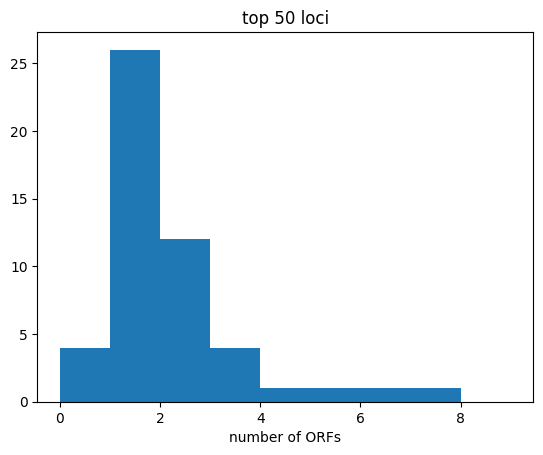

In [16]:
plt.hist([len(_) for _ in all_possible_orfs[:50]], bins = np.arange(0,10,1))
plt.title("top 50 loci")
plt.xlabel("number of ORFs")

Text(0.5, 0, 'number of ORFs')

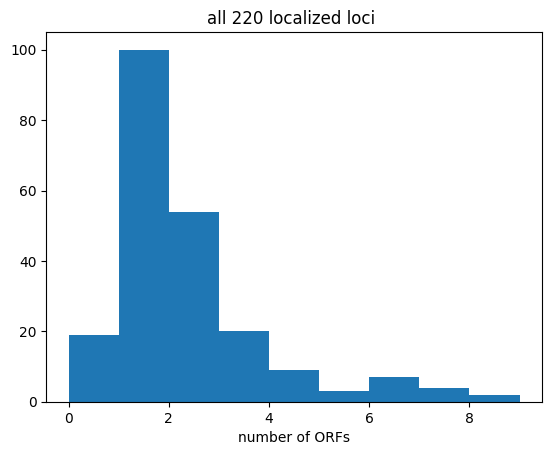

In [17]:
plt.hist([len(_) for _ in all_possible_orfs], bins = np.arange(0,10,1))
plt.title(f"all {len(all_possible_orfs)} localized loci ")
plt.xlabel("number of ORFs")

## Get annotations of confident ORFs and save in data frame

In [18]:
fh = open(f"{new_dir}/orf_names.txt", "w")
fh.write(" ".join(all_orfs))
fh.close()

pickle.dump(loci_to_possible_orfs_d, open(f"{new_dir}/loci_to_possible_orfs_d", "wb"))
#loci_to_possible_orfs_d = pickle.load(open(f"{new_dir}/loci_to_possible_orfs_d", "rb"))

In [24]:
# upload file for process and function annotations here: https://www.yeastgenome.org/goSlimMapper
# save tab delinated results to 
fun_anno = f"{new_dir}/go_annotations_function.txt"
proc_anno = f"{new_dir}/go_annotations_process.txt"

In [25]:
# use https://yeastmine.yeastgenome.org/yeastmine/begin.do to get annotations for orf_names.txt 
# ignored ones with ambigous labels
# make columns: 0: 'Systematic Gene Name', 1:'Standard Gene Name',2:'Long Gene Name',3:'Brief Description',4:'Description', 5:'Function Summary'
# save tab delinated results to 
gene_anno = f"{new_dir}/gene_anno.tsv"


In [26]:
all_orfs = []
for key in loci_to_possible_orfs_d:
    all_orfs += loci_to_possible_orfs_d[key]
print(len(all_orfs))
all_orfs = list(set(all_orfs))
print(len(all_orfs))

df = pd.read_csv(gene_anno, sep = '\t', header=None)#, cols = ["name1", "name2", "func","description"])
df = df.set_index(0)
df.rename(columns = {0:'Systematic Gene Name', 1:'Standard Gene Name',2:'Long Gene Name',3:'Brief Description',4:'Description', 5:'Function Summary'}, inplace = True)


for orf in all_orfs:
    if orf not in df.index:
        df.loc[orf] = [None, None, None, None, None]

cl_description_proc = dict.fromkeys(df.index)
for key in cl_description_proc:
    cl_description_proc[key] = []
fh = open(proc_anno, 'r')
fh.readline()
for line in fh.readlines():
    ll = line.split('\t')
    name = f"{ll[1]} ({ll[2]})"
    li = ll[-1].strip().split(', ')
    for _ in li:
        if _=="SNR30": _ = "snR30"
        if _=="SNR31": _ = "snR31"
        if _=="SNR62": _ = "snR62"
        if _=="SNR9": _ = "snR9"
        if _=="TP(UGG)O3": _ = "tP(UGG)O3"
        if _=="TE(UGG)O3": _ = "tE(UGG)O3"
        if _=="TE(UUC)M": _ = "tE(UUC)M"
        cl_description_proc[_].append(name)
for _ in cl_description_proc.keys():
    cl_description_proc[_] = " ".join(cl_description_proc[_])


cl_description_func = dict.fromkeys(df.index)
for key in cl_description_func:
    cl_description_func[key] = []
fh = open(fun_anno, 'r')
fh.readline()
for line in fh.readlines():
    ll = line.split('\t')
    name = f"{ll[1]} ({ll[2]})"
    li = ll[-1].strip().split(', ')
    for _ in li:
        if _=="SNR30": _ = "snR30"
        if _=="SNR31": _ = "snR31"
        if _=="SNR62": _ = "snR62"
        if _=="SNR9": _ = "snR9"
        if _=="TP(UGG)O3": _ = "tP(UGG)O3"
        if _=="TE(UGG)O3": _ = "tE(UGG)O3"
        if _=="TE(UUC)M": _ = "tE(UUC)M"
        cl_description_func[_].append(name)
for _ in cl_description_func.keys():
    cl_description_func[_] = " ".join(cl_description_func[_])


df["GO_Function"] = [cl_description_func[_] for _ in df.index]
df["GO_Process"] = [cl_description_proc[_] for _ in df.index]

df

df.to_csv(f'{new_dir}/orf_info.csv')

428
345


In [27]:
df

,Standard Gene Name,Long Gene Name,Brief Description,Description,Function Summary,GO_Function,GO_Process
0,,,,,,,
YAL051W,OAF1,Oleate-Activated transcription Factor,Oleate-activated transcription factor,Oleate-activated transcription factor; subunit...,Subunit of the heterodimeric Pip2-Oaf1 complex...,DNA binding (26) DNA-binding transcription fac...,response to chemical (35) transcription by RNA...
YAL053W,FLC2,FLavin Carrier,Putative calcium channel involved in calcium r...,Putative calcium channel involved in calcium r...,FAD transmembrane transporter involved in hypo...,transmembrane transporter activity (26),response to chemical (35) ion transport (19) t...
YAL056W,GPB2,NaN,Multistep regulator of cAMP-PKA signaling,Multistep regulator of cAMP-PKA signaling; inh...,GAP-binding cAMP-dependent protein kinase inhi...,enzyme regulator activity (14),response to chemical (35) transcription by RNA...
YBL011W,SCT1,Suppressor of Choline-Transport mutants,Glycerol 3-phosphate/dihydroxyacetone phosphat...,Glycerol 3-phosphate/dihydroxyacetone phosphat...,Glycerol-3-phosphate- and glycerone-phosphate ...,,lipid metabolic process (18)
YBR111C,YSA1,NaN,Nudix hydrolase family member with ADP-ribose ...,Nudix hydrolase family member with ADP-ribose ...,ADP-ribose diphosphatase involved in ribose ph...,hydrolase activity (8),
...,...,...,...,...,...,...,...
YDL012C_mRNA,None,None,None,None,None,,
YDR064W_intron,None,None,None,None,None,,
ARS719,None,None,None,None,None,,
